In [1]:
import geopandas as gpd
import pandas as pd
import requests
from dep_tools.grids import PACIFIC_EPSG
from fiona.io import ZipMemoryFile
from odc.geo.geom import Geometry
from odc.geo.xr import mask
from odc.stac import load
from pystac.client import Client
from xarray import DataArray, Dataset

In [2]:
# First get the country EEZs
url = "https://files.auspatious.com/unsw/EEZ_land_union_v4_202410.zip"
source_internal_path_name = "EEZ_land_union_v4_202410/EEZ_land_union_v4_202410.shp"
zip_bytes = requests.get(url).content

with ZipMemoryFile(zip_bytes) as z:
    with z.open(source_internal_path_name) as src:
        eez = gpd.GeoDataFrame.from_features(src, crs=src.crs)

In [3]:
# eez.explore()

In [4]:
# Only do Vanuatu
eez_vanuatu = eez[eez["ISO_SOV1"] == "VUT"].to_crs("EPSG:4326")

# Convert to ODC Geometry
eez_vanuatu_geom = Geometry(eez_vanuatu.geometry.values[0], crs=eez_vanuatu.crs)
# eez_vanuatu.explore()

In [5]:
# Get some seagrass data for the area
client = Client.open("https://stac.digitalearthpacific.org")
items = client.search(
    collections=["dep_s2_seagrass"],
    intersects=eez_vanuatu_geom.json
).item_collection()

print(f"Found {len(items)} items")

data = load(
    items,
    bands=["seagrass"],
    crs=PACIFIC_EPSG,  # 
    resolution=100,  # Change to 10 for full resolution,
    chunks={"x": 2048, "y": 2048}
)
data

Found 32 items


<xarray.Dataset> Size: 207MB
Dimensions:      (y: 6720, x: 3840, time: 8)
Coordinates:
  * y            (y) float64 54kB -1.6e+06 -1.6e+06 ... -2.272e+06 -2.272e+06
  * x            (x) float64 31kB 1.8e+06 1.8e+06 ... 2.184e+06 2.184e+06
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 64B 2017-01-01 2018-01-01 ... 2024-01-01
Data variables:
    seagrass     (time, y, x) uint8 206MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

In [6]:
def xarray_calculate_area(
    data: Dataset | DataArray,
    geom: Geometry,
    variable: str | None = None,
    value: int | float | None = None,
) -> float:
    # Work with a dataarray, not a dataset, so it's a singular thing
    if type(data) is not DataArray:
        if variable is None:
            raise ValueError("Variable must be specified when data is a Dataset.")
        data = data[variable]

    # Only select a specific value. This will convert to float, with nans
    if value is not None:
        data = data.where(data == value)

    # Mask out regions outsize the geometry
    masked = mask(data, geom.to_crs(data.odc.crs))

    # Count all the non-nan cells, and multiply by area
    count = float(masked.notnull().sum().values)
    one_pixel_area = abs(
        masked.odc.geobox.resolution.x * masked.odc.geobox.resolution.y
    )

    return float(count) * one_pixel_area

/opt/homebrew/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


<Axes: title={'center': 'Vanuatu Seagrass Area Over Time'}, xlabel='time'>

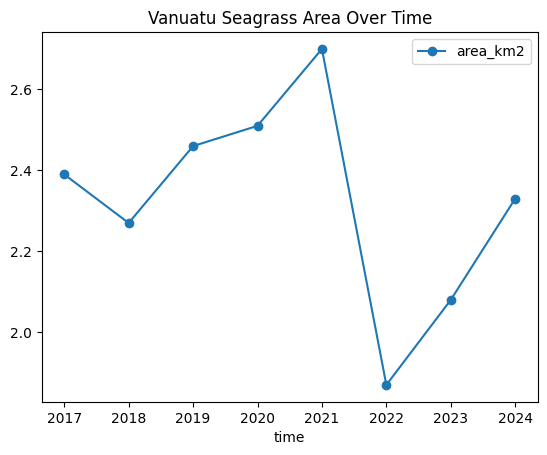

In [7]:
# Run the xarray_calculate_area per time step
results = []
for time in data.time:
    da = data.sel(time=time)
    area_m2 = xarray_calculate_area(da, eez_vanuatu_geom, variable="seagrass", value=1)
    # Year, in YYYY, area in m2, area in km2
    results.append({
        "time": pd.to_datetime(time.values).year,
        "area_m2": area_m2,
        "area_km2": area_m2 / 1e6
    })

df = pd.DataFrame(results)
df

df.plot(x="time", y="area_km2", marker="o", title="Vanuatu Seagrass Area Over Time")

In [8]:
for r in results:
    print(f"{r['time']}: {r['area_km2']:.2f} km²")

2017: 2.39 km²
2018: 2.27 km²
2019: 2.46 km²
2020: 2.51 km²
2021: 2.70 km²
2022: 1.87 km²
2023: 2.08 km²
2024: 2.33 km²
